In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Leitura e preparação dos dados

In [2]:
ds = pd.read_csv("../datasets/EN_03_terciary_data.csv", sep = ";", index_col = 0)
ds.head()

,name,category,level,description,input,output,has_images,s_level,submissions,solved,ratio
1001,Extremely Basic,Beginner,5,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,False,5 / 10,816938,236060,28.90%
1002,Area of a Circle,Beginner,5,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",False,5 / 10,650389,166254,25.56%
1003,Simple Sum,Beginner,2,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,False,2 / 10,313933,165940,52.86%
1004,Simple Product,Beginner,1,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",False,1 / 10,238645,158387,66.37%
1005,Average 1,Beginner,4,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,False,4 / 10,342625,136210,39.75%


In [3]:
ds = ds[["name", "description", "input", "output", "category", "level", "submissions", "solved"]]
ds["ratio"] = (ds["solved"] / ds["submissions"]).round(3)
ds.head()

,name,description,input,output,category,level,submissions,solved,ratio
1001,Extremely Basic,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,Beginner,5,816938,236060,0.289
1002,Area of a Circle,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",Beginner,5,650389,166254,0.256
1003,Simple Sum,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,Beginner,2,313933,165940,0.529
1004,Simple Product,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",Beginner,1,238645,158387,0.664
1005,Average 1,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,Beginner,4,342625,136210,0.398


## Informações estatísticas

<Axes: xlabel='level', ylabel='ratio'>

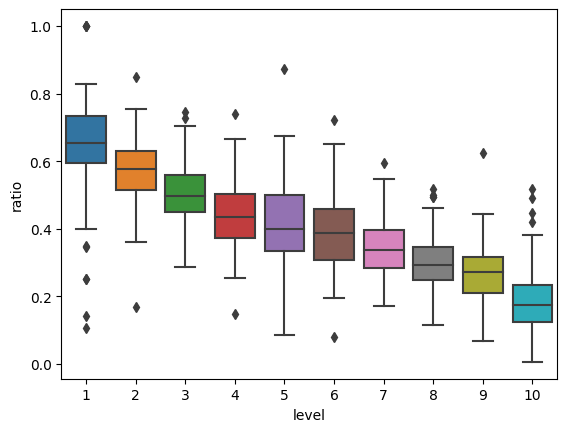

In [4]:
sns.boxplot(ds, x = "level", y = "ratio")

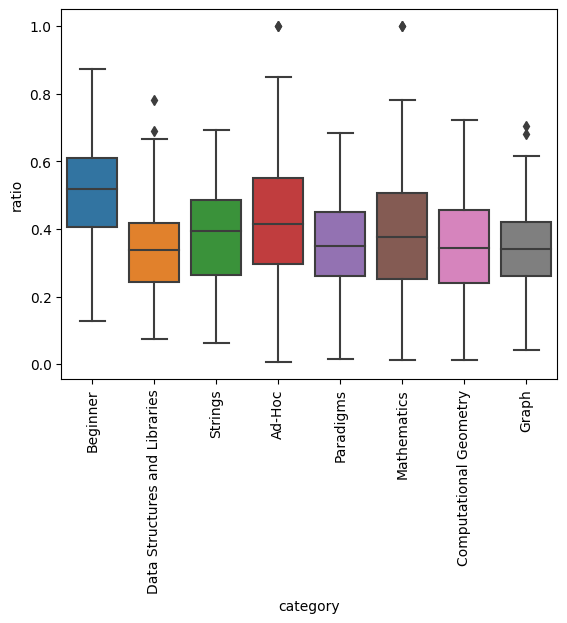

In [5]:
g = sns.boxplot(ds, x = "category", y = "ratio")
g.tick_params(axis='x', rotation=90)

In [6]:
ds[["level", "ratio"]].corr()

,level,ratio
level,1.000000,-0.803776
ratio,-0.803776,1.000000


In [7]:
ds[["level", "ratio"]].describe()

,level,ratio
count,1833.000000,1833.000000
mean,5.515548,0.404763
std,2.850899,0.166159
min,1.000000,0.006000
25%,3.000000,0.286000
50%,6.000000,0.392000
75%,8.000000,0.518000
max,10.000000,1.000000


## Definição do nível de dificuldade conforme a taxa de acerto (via regressão linear)

In [8]:
dsn_q1 = ds[["level", "ratio"]].groupby("level").quantile(0.25).copy()
dsn_q3 = ds[["level", "ratio"]].groupby("level").quantile(0.75).copy()

iqr = dsn_q3 - dsn_q1

dsn_q1 = (dsn_q1 - (1.5 * iqr))
dsn_q3 = (dsn_q3 + (1.5 * iqr))

dsn_q1 = dsn_q1.rename(columns = {"ratio": "ratio_inf"})
dsn_q3 = dsn_q3.rename(columns = {"ratio": "ratio_sup"})

dsn_qs = dsn_q1.join(dsn_q3)
dsn_qs

,ratio_inf,ratio_sup
level,,
1,0.388125,0.941125
2,0.342500,0.802500
3,0.284000,0.724000
4,0.178750,0.696750
5,0.084500,0.748500
6,0.080125,0.683125
7,0.119000,0.561000
8,0.103500,0.491500
9,0.048625,0.477625


### Remoção dos dados fora da amplitude interquartil

In [9]:
dsn = ds[["level", "ratio"]].copy().join(dsn_qs, on = ["level"])
dsn = dsn[(dsn["ratio"] <= dsn["ratio_sup"]) & (dsn["ratio"] >= dsn["ratio_inf"])]
dsn.head()

,level,ratio,ratio_inf,ratio_sup
1001,5,0.289,0.084500,0.748500
1002,5,0.256,0.084500,0.748500
1003,2,0.529,0.342500,0.802500
1004,1,0.664,0.388125,0.941125
1005,4,0.398,0.178750,0.696750


<Axes: xlabel='level', ylabel='ratio'>

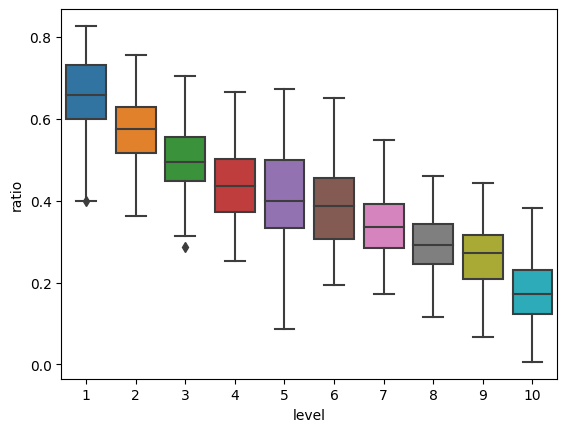

In [10]:
dsn = dsn[["level", "ratio"]]
sns.boxplot(dsn, x = "level", y = "ratio")

In [11]:
print("All size", ds.shape)
print("Train size", dsn.shape)
dsn.corr()

All size (1833, 9)
Train size (1804, 2)


,level,ratio
level,1.000000,-0.830722
ratio,-0.830722,1.000000


### Regressão linear e cálculo dos novos filtros (predict)

In [12]:
lr = LinearRegression().fit(dsn[["ratio"]], dsn["level"])

ds = ds.join(dsn_qs, on = ["level"])
ds["n_level"] = lr.predict(ds[["ratio"]])
ds["n_level"] = ds["n_level"].clip(1, 10).round().astype(int)
ds["n_level"] = np.where(((ds["ratio"] <= ds["ratio_sup"]) & (ds["ratio"] >= ds["ratio_inf"])), ds["level"], ds["n_level"])
ds = ds.drop(columns = ["ratio_inf", "ratio_sup"])

ds.head()

,name,description,input,output,category,level,submissions,solved,ratio,n_level
1001,Extremely Basic,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,Beginner,5,816938,236060,0.289,5
1002,Area of a Circle,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",Beginner,5,650389,166254,0.256,5
1003,Simple Sum,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,Beginner,2,313933,165940,0.529,2
1004,Simple Product,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",Beginner,1,238645,158387,0.664,1
1005,Average 1,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,Beginner,4,342625,136210,0.398,4


In [13]:
ds[["n_level", "ratio"]].corr()

,n_level,ratio
n_level,1.000000,-0.831772
ratio,-0.831772,1.000000


In [14]:
ds[["level", "n_level"]].corr()

,level,n_level
level,1.0000,0.9767
n_level,0.9767,1.0000


<Axes: xlabel='n_level', ylabel='ratio'>

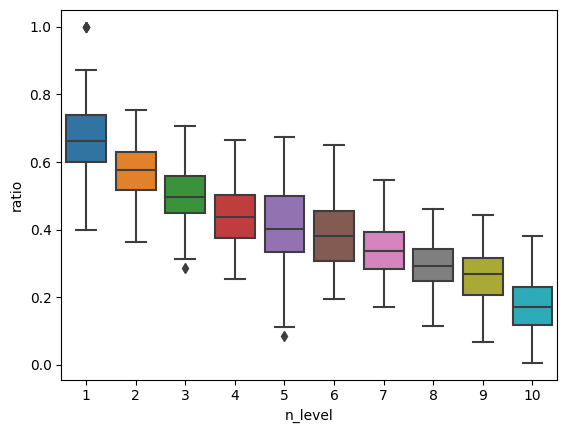

In [15]:
sns.boxplot(ds, x = "n_level", y = "ratio")

#### Análise das classes

<Axes: xlabel='level', ylabel='Count'>

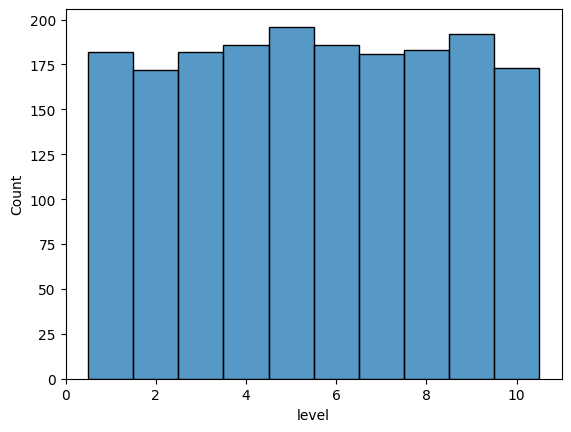

In [16]:
ds = ds[["description", "input", "output", "n_level"]].rename(columns = { "n_level": "level" })
sns.histplot(ds, x = "level", bins = 10, discrete = True)

In [17]:
pd.DataFrame(ds["level"].value_counts()).describe()

,count
count,10.000000
mean,183.300000
std,7.409453
min,172.000000
25%,181.250000
50%,182.500000
75%,186.000000
max,196.000000


## Preprocessamento textual

In [18]:
ds[["description", "input", "output"]] = ds[["description", "input", "output"]].applymap(str)
ds.head()

,description,input,output,level
1001,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,5
1002,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",5
1003,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,2
1004,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",1
1005,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,4


### Uso de TF-IDF

In [19]:
dtf = ds.copy()
vctzr = TfidfVectorizer(
    input = "content",
    encoding = "utf-8",
    strip_accents = "unicode",
    tokenizer = word_tokenize,
    analyzer = "word",
    stop_words = "english"
)

dtf["description"] = dtf["description"] + " " + dtf["input"] + " " + dtf["output"]
dtf = dtf[["description", "level"]]

In [20]:
tfidf = vctzr.fit_transform(dtf["description"])

C:\Users\mauro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
dim = 384 * 3
svd = TruncatedSVD(n_components = dim, n_iter = 10)
tfidf = svd.fit_transform(tfidf)

##### Redução de dimensionalidade e reconstrução do DataFrame

In [22]:
dtf = pd.concat([
    pd.DataFrame(tfidf, columns = [f"d{i}" for i in range(dim)], index = dtf.index),
    dtf[["level"]]
], axis = 1)
dtf.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d1143,d1144,d1145,d1146,d1147,d1148,d1149,d1150,d1151,level
1001,0.275126,-0.044929,0.210427,-0.051665,-0.144573,0.072281,-0.036234,-0.066196,-0.040832,0.213544,...,-0.013026,-0.014580,-0.007011,0.009341,-0.010024,0.007396,0.040697,0.004910,-0.020670,5
1002,0.256531,-0.038217,0.130494,0.037456,-0.107715,0.009932,-0.139790,-0.057710,0.113800,0.070828,...,-0.014779,-0.026979,0.022952,-0.007590,0.017533,-0.003210,0.020743,0.015468,-0.031451,5
1003,0.275035,-0.036405,0.161043,0.015617,-0.139574,0.092189,-0.167711,-0.008031,-0.017926,0.104075,...,0.001145,0.011039,-0.010460,-0.019409,-0.029311,-0.017330,-0.004986,-0.011227,0.002917,2
1004,0.260520,-0.046839,0.181581,-0.021893,-0.158150,0.086272,-0.114478,-0.118435,-0.104887,0.099324,...,0.004635,0.012055,0.020847,-0.002499,-0.008254,0.025335,0.004015,-0.008868,0.006023,1
1005,0.287393,-0.042896,0.219366,0.013176,0.010162,0.010516,-0.091642,-0.156985,-0.037398,0.132111,...,-0.006498,-0.000243,0.005384,0.009801,0.000442,-0.001664,0.009535,-0.006291,0.017145,4


### Uso de embedding

#### Tratamento de problemas com mais de 512 tokens (palavras)

In [23]:
de = ds.copy()
for c in ["description", "input", "output"]:
    de[c] = np.where(de[c].apply(lambda x: len(word_tokenize(x))) > 512, de[c].apply(lambda x: re.sub(r"[^\w\s\b']+", " ", x)), de[c])
    de[c] = np.where(de[c].apply(lambda x: len(word_tokenize(x))) > 512, de[c].apply(lambda x: re.sub(r"\b\w{1,2}\b", " ", x)), de[c])
    de[c] = np.where(de[c].apply(lambda x: len(word_tokenize(x))) > 512, de[c].apply(lambda x: re.sub(r"\b\w{1,3}\b", " ", x)), de[c])
    de[c] = de[c].apply(lambda x: re.sub(r"\s+", " ", x)) #normalizes spacing
    info = de[c].apply(lambda x: len(word_tokenize(x)))
    print(f"-> Column {c}:\n  -Maximum number of words: {max(info)}.\n  -Quantity of truncated texts: {len(info[info > 512])}")

-> Column description:
  -Maximum number of words: 512.
  -Quantity of truncated texts: 0
-> Column input:
  -Maximum number of words: 433.
  -Quantity of truncated texts: 0
-> Column output:
  -Maximum number of words: 247.
  -Quantity of truncated texts: 0


### Importação do transformador de sentenças

In [24]:
#all-MiniLM-L6-v2 (trunca em 256 palavras, mapeia para espaço de 384 dimensões)
#multi-qa-MiniLM-L6-cos-v1 (trunca em 512 palavras, mapeia para espaço de 384 dimensões)
#multi-qa-MiniLM-L6-dot-v1 (trunca em 512 palavras, mapeia para espaço de 384 dimensões)
#multi-qa-distilbert-cos-v1 (trunca em 512 palavras, mapeia para espaço de 768 dimensões)
#all-distilroberta-v1 (trunca em 512 palavras, mapeia para espaço de 768 dimensões)
emb_transformer = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

### Vetorização dos textos

In [25]:
ncols = []
for c in ["description", "input", "output"]:
    ccols = [f"{c[0:3]}{i}" for i in range(384)]
    ncols += ccols
    de = pd.concat([de, pd.DataFrame(emb_transformer.encode(de[c].to_list()), index = list(de.index),columns = ccols)], axis = 1)
de = de[ncols + ["level"]]
ds.head()

,description,input,output,level
1001,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,5
1002,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",5
1003,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,2
1004,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",1
1005,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,4


## Geração dos classificadores

#### Valores comuns

In [26]:
scoring = ["balanced_accuracy", "precision_weighted", "f1_weighted", "roc_auc_ovo_weighted"]
scr_cols = [p + s for s in scoring for p in ["rank_test_", "mean_train_", "mean_test_"]]
refit_idx = 0

rf_grid = {
    "n_estimators": list(range(20, 121, 20)),
    "max_depth": [5, 7, 9, 11, 13, 15],
    "min_samples_leaf": [5, 10, 15, 20],
    "min_impurity_decrease": [0.001, 0.01, 0.1]
}
knn_grid = {
    "n_neighbors": [11, 15, 21, 31],
    "metric": ["euclidean", "cosine"],
    "weights": ["uniform", "distance"]
}

df_res_col_name = lambda c: re.sub(r"(mean|std|rank)_(test|train)_(\w+?)_weighted", r"\1_\2_\3", c.replace("param_", ""))

#### Classificadores TF-IDF

##### Busca por "melhor" floresta aleatória

In [27]:
gsttf = GridSearchCV(
    estimator = RandomForestClassifier(criterion = "gini", max_features = "log2"),
    param_grid = rf_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsttf.fit(dtf.drop(columns = ["level"]), dtf["level"])

GridSearchCV(cv=10, estimator=RandomForestClassifier(max_features='log2'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [20, 40, 60, 80, 100, 120]},
             refit='balanced_accuracy', return_train_score=True,
             scoring=['balanced_accuracy', 'precision_weighted', 'f1_weighted',
                      'roc_auc_ovo_weighted'])

In [28]:
evt_cols = [
    *[f"param_{p}" for p in rf_grid.keys()],
    *scr_cols
]
dfgsttf = pd.DataFrame(gsttf.cv_results_)
dfgsttf[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_estimators,max_depth,min_samples_leaf,min_impurity_decrease,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
220,100,11,5,0.001,1,0.994708,0.125781,1,0.994780,0.129157,1,0.994730,0.122401,2,0.999900,0.528768
221,120,11,5,0.001,2,0.994831,0.121753,3,0.994938,0.125314,2,0.994906,0.116361,27,0.999919,0.520892
363,80,15,5,0.001,3,0.995421,0.119733,15,0.995472,0.118234,3,0.995453,0.116070,80,0.999888,0.512903
229,40,11,15,0.001,4,0.923829,0.118260,13,0.926627,0.118744,4,0.924740,0.114555,73,0.993132,0.515054
93,80,7,20,0.001,5,0.918955,0.117549,9,0.926092,0.121230,14,0.920805,0.108471,10,0.993943,0.525497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,40,15,20,0.001,428,0.900624,0.094669,140,0.905045,0.095617,126,0.901782,0.091325,56,0.989769,0.516579
239,120,11,20,0.001,429,0.989928,0.094526,134,0.990244,0.096580,140,0.990123,0.086469,30,0.999272,0.519597
82,100,7,10,0.001,430,0.966216,0.093985,127,0.967678,0.098178,132,0.966862,0.089254,39,0.997960,0.518085
16,100,5,15,0.001,431,0.838302,0.092491,135,0.865556,0.096543,144,0.842139,0.080524,120,0.984681,0.507072


##### Busca por "melhor" classificador baseado em vizinhança

In [29]:
gsntf = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = knn_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsntf.fit(dtf.drop(columns = ["level"]).values, dtf["level"].values)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'cosine'],
                         'n_neighbors': [11, 15, 21, 31],
                         'weights': ['uniform', 'distance']},
             refit='balanced_accuracy', return_train_score=True,
             scoring=['balanced_accuracy', 'precision_weighted', 'f1_weighted',
                      'roc_auc_ovo_weighted'])

In [30]:
evn_cols = [
    *[f"param_{p}" for p in knn_grid.keys()],
    *scr_cols
]
dfgsntf = pd.DataFrame(gsntf.cv_results_)
dfgsntf[evn_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,param_n_neighbors,param_metric,param_weights,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
5,21,euclidean,distance,1,0.995685,0.126377,7,0.995668,0.120934,8,0.995639,0.111213,6,0.999993,0.538863
13,21,cosine,distance,2,0.996781,0.126262,6,0.996769,0.121869,3,0.996732,0.115527,8,0.999996,0.531288
12,21,cosine,uniform,3,0.257918,0.125633,8,0.257649,0.119430,1,0.253069,0.117155,7,0.737837,0.532464
15,31,cosine,distance,4,0.996781,0.123152,4,0.996769,0.122947,7,0.996732,0.111425,5,0.999996,0.539649
4,21,euclidean,uniform,5,0.264586,0.122536,2,0.270884,0.123265,5,0.259729,0.113906,3,0.744127,0.541377
7,31,euclidean,distance,6,0.995690,0.122232,5,0.995672,0.122601,15,0.995639,0.106334,2,0.999993,0.545829
2,15,euclidean,uniform,7,0.282008,0.121290,9,0.285866,0.117879,4,0.279611,0.114097,9,0.768785,0.527711
11,15,cosine,distance,8,0.996781,0.121098,11,0.996769,0.117252,6,0.996732,0.112861,12,0.999996,0.525559
6,31,euclidean,uniform,9,0.232969,0.120993,1,0.249151,0.126028,9,0.225119,0.110589,1,0.718299,0.547034
10,15,cosine,uniform,10,0.275559,0.120715,3,0.274818,0.123164,2,0.272444,0.117006,11,0.764617,0.525597


#### Classificadores embeddings

##### Busca por "melhor" floresta aleatória

In [31]:
gste = GridSearchCV(
    estimator = RandomForestClassifier(criterion = "gini", max_features = "log2"),
    param_grid = rf_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gste.fit(de.drop(columns = ["level"]), de["level"])

GridSearchCV(cv=10, estimator=RandomForestClassifier(max_features='log2'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [20, 40, 60, 80, 100, 120]},
             refit='balanced_accuracy', return_train_score=True,
             scoring=['balanced_accuracy', 'precision_weighted', 'f1_weighted',
                      'roc_auc_ovo_weighted'])

In [32]:
evt_cols = [
    *[f"param_{p}" for p in rf_grid.keys()],
    *scr_cols
]
dfgste = pd.DataFrame(gste.cv_results_)
dfgste[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_estimators,max_depth,min_samples_leaf,min_impurity_decrease,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
2,60,5,5,0.001,1,0.750827,0.141643,4,0.770753,0.145556,3,0.754254,0.132944,49,0.953735,0.567399
293,120,13,5,0.001,2,0.992803,0.139955,8,0.992923,0.142086,4,0.992857,0.132879,79,0.999627,0.560272
163,40,9,20,0.001,3,0.811051,0.138654,12,0.822142,0.138448,7,0.812514,0.129715,46,0.970895,0.568553
85,40,7,15,0.001,4,0.784991,0.138606,5,0.794833,0.145379,2,0.786184,0.134162,51,0.964684,0.567110
368,60,15,10,0.001,5,0.977996,0.137595,27,0.978875,0.132864,10,0.978321,0.129000,52,0.998001,0.566839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,120,9,10,0.01,144,0.100000,0.100000,145,0.011434,0.011440,145,0.020659,0.020667,149,0.500000,0.500000
178,100,9,10,0.01,144,0.100000,0.100000,145,0.011434,0.011440,145,0.020659,0.020667,149,0.500000,0.500000
185,120,9,15,0.01,144,0.100000,0.100000,145,0.011434,0.011440,145,0.020659,0.020667,149,0.500000,0.500000
431,120,15,20,0.1,144,0.100000,0.100000,145,0.011434,0.011440,145,0.020659,0.020667,149,0.500000,0.500000


#### Busca por "melhor" classificador baseado em vizinhança

In [33]:
gsne = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = knn_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsne.fit(de.drop(columns = ["level"]).values, de["level"].values)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'cosine'],
                         'n_neighbors': [11, 15, 21, 31],
                         'weights': ['uniform', 'distance']},
             refit='balanced_accuracy', return_train_score=True,
             scoring=['balanced_accuracy', 'precision_weighted', 'f1_weighted',
                      'roc_auc_ovo_weighted'])

In [34]:
evn_cols = [
    *[f"param_{p}" for p in knn_grid.keys()],
    *scr_cols
]
dfgsn = pd.DataFrame(gsne.cv_results_)
dfgsn[evn_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,param_n_neighbors,param_metric,param_weights,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
15,31,cosine,distance,1,0.998389,0.136186,3,0.998371,0.134977,1,0.998363,0.130048,4,0.999999,0.559025
7,31,euclidean,distance,2,0.997258,0.135630,4,0.997279,0.134381,2,0.997272,0.129561,1,0.999997,0.560151
3,15,euclidean,distance,3,0.997269,0.134824,1,0.997281,0.136095,3,0.997272,0.129474,11,0.999997,0.545921
11,15,cosine,distance,4,0.998389,0.134298,2,0.998371,0.135317,4,0.998363,0.128796,12,0.999999,0.544912
13,21,cosine,distance,5,0.998389,0.131344,5,0.998371,0.132265,5,0.998363,0.125266,8,0.999999,0.552887
6,31,euclidean,uniform,6,0.243144,0.131202,11,0.242462,0.128778,6,0.240365,0.124826,2,0.721401,0.559628
14,31,cosine,uniform,6,0.243144,0.131202,11,0.242468,0.128778,6,0.240365,0.124826,3,0.721388,0.559619
5,21,euclidean,distance,8,0.997258,0.130815,10,0.997279,0.130688,8,0.997272,0.124292,7,0.999997,0.553568
2,15,euclidean,uniform,9,0.282335,0.129532,9,0.283547,0.130849,10,0.280776,0.123751,10,0.774745,0.546147
10,15,cosine,uniform,9,0.282342,0.129532,7,0.283544,0.130903,9,0.280771,0.123773,9,0.774722,0.546296


### Agrupamento de classes (redefinição de 10 para 5 classes)

In [35]:
new_target_lvl = np.ceil(de["level"] / 2).astype(int)

#### TF-IDF

##### Árvore

In [36]:
gsttfr = GridSearchCV(
    estimator = RandomForestClassifier(criterion = "gini", max_features = "log2"),
    param_grid = rf_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsttfr.fit(dtf.drop(columns = ["level"]), new_target_lvl)
evt_cols = [
    *[f"param_{p}" for p in rf_grid.keys()],
    *scr_cols
]
dfgsttfr = pd.DataFrame(gsttfr.cv_results_)
dfgsttfr[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_estimators,max_depth,min_samples_leaf,min_impurity_decrease,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
231,80,11,15,0.001,1,0.985805,0.232483,9,0.985950,0.232068,2,0.985880,0.226223,11,0.998485,0.542129
375,80,15,15,0.001,2,0.989986,0.231908,4,0.990113,0.239047,1,0.990060,0.226353,20,0.998686,0.537934
23,120,5,20,0.001,3,0.888527,0.231104,1,0.897485,0.248727,6,0.890033,0.221367,6,0.984333,0.544322
239,120,11,20,0.001,4,0.988251,0.230341,3,0.988376,0.241706,3,0.988304,0.226152,2,0.998319,0.547999
306,20,13,20,0.001,5,0.771029,0.227095,11,0.774147,0.230631,4,0.771448,0.225691,99,0.941521,0.524150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,20,5,10,0.001,428,0.609552,0.192365,141,0.620006,0.191926,140,0.610289,0.188146,432,0.863989,0.493505
150,20,9,10,0.001,429,0.836764,0.192115,138,0.838614,0.193151,139,0.837204,0.189846,431,0.964085,0.493652
365,120,15,5,0.001,430,0.995582,0.191690,142,0.995606,0.190049,142,0.995578,0.186238,185,0.999639,0.514617
390,20,15,10,0.01,431,0.211093,0.189354,180,0.075854,0.046899,168,0.094095,0.073880,245,0.520615,0.506254


##### Vizinhança

In [37]:
gsntfr = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = knn_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsntfr.fit(dtf.drop(columns = ["level"]).values, new_target_lvl.values)
dfgsntfr = pd.DataFrame(gsntfr.cv_results_)
evt_cols = [
    *[f"param_{p}" for p in knn_grid.keys()],
    *scr_cols
]
dfgsntfr[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_neighbors,metric,weights,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
3,15,euclidean,distance,1,0.995636,0.245083,3,0.995665,0.242310,6,0.995641,0.227243,12,0.999986,0.550152
4,21,euclidean,uniform,2,0.379869,0.242666,8,0.393529,0.234718,7,0.374859,0.224413,5,0.714285,0.560578
0,11,euclidean,uniform,3,0.422319,0.242610,1,0.423850,0.243377,1,0.419534,0.235912,11,0.756863,0.550743
2,15,euclidean,uniform,4,0.395785,0.240648,6,0.402154,0.237853,4,0.391794,0.229263,13,0.734749,0.549718
12,21,cosine,uniform,5,0.370296,0.240268,7,0.375622,0.237237,3,0.367024,0.229280,7,0.711726,0.559364
6,31,euclidean,uniform,6,0.351362,0.239521,5,0.380763,0.238361,13,0.341510,0.216013,1,0.697463,0.572568
10,15,cosine,uniform,7,0.388085,0.238664,12,0.389991,0.233135,5,0.385647,0.228066,9,0.733057,0.553802
5,21,euclidean,distance,8,0.995636,0.238068,15,0.995665,0.230170,14,0.995641,0.214293,6,0.999986,0.559957
7,31,euclidean,distance,9,0.995636,0.236872,13,0.995665,0.231944,16,0.995641,0.207477,2,0.999986,0.572073
1,11,euclidean,distance,10,0.995636,0.236343,4,0.995665,0.239101,8,0.995641,0.223515,14,0.999986,0.549367


#### Embedding

##### Árvore

In [38]:
gster = GridSearchCV(
    estimator = RandomForestClassifier(criterion = "gini", max_features = "log2"),
    param_grid = rf_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gster.fit(de.drop(columns = ["level"]), new_target_lvl)
evt_cols = [
    *[f"param_{p}" for p in rf_grid.keys()],
    *scr_cols
]
dfgster = pd.DataFrame(gster.cv_results_)
dfgster[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_estimators,max_depth,min_samples_leaf,min_impurity_decrease,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
15,80,5,15,0.001,1,0.787229,0.281938,5,0.792529,0.276772,2,0.787171,0.267670,35,0.934278,0.595958
83,120,7,10,0.001,2,0.944363,0.280513,1,0.945071,0.283809,1,0.944549,0.268027,2,0.986994,0.603672
88,100,7,15,0.001,3,0.906394,0.278763,2,0.907899,0.281618,4,0.906582,0.264719,25,0.976355,0.598152
309,80,13,20,0.001,4,0.909828,0.278106,6,0.911146,0.275668,3,0.909984,0.264914,4,0.977760,0.602492
94,100,7,20,0.001,5,0.877558,0.276439,3,0.879961,0.280616,9,0.877594,0.261760,21,0.965810,0.599329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,60,11,5,0.01,428,0.204076,0.197047,189,0.073272,0.051531,182,0.080310,0.074962,177,0.575552,0.542933
402,20,15,20,0.01,429,0.207803,0.196623,169,0.088473,0.060624,156,0.094725,0.083769,249,0.549419,0.519742
241,40,11,5,0.01,430,0.203096,0.195974,208,0.048722,0.045816,187,0.078347,0.074243,285,0.543637,0.505878
319,40,13,10,0.01,431,0.205585,0.195876,197,0.074584,0.048618,195,0.082593,0.073787,263,0.561909,0.516629


##### Vizinhança

In [40]:
gsner = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = knn_grid,
    scoring = scoring,
    n_jobs = -1,
    refit = scoring[refit_idx],
    cv = 10,
    return_train_score = True
)
gsner.fit(de.drop(columns = ["level"]).values, new_target_lvl.values)
dfgsner = pd.DataFrame(gsner.cv_results_)
evt_cols = [
    *[f"param_{p}" for p in knn_grid.keys()],
    *scr_cols
]
dfgsner[evt_cols].rename(columns = { c: df_res_col_name(c) for c in evt_cols}).sort_values(f"rank_test_{df_res_col_name(scoring[refit_idx])}")

,n_neighbors,metric,weights,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_balanced_accuracy,rank_test_precision,mean_train_precision,mean_test_precision,rank_test_f1,mean_train_f1,mean_test_f1,rank_test_roc_auc_ovo,mean_train_roc_auc_ovo,mean_test_roc_auc_ovo
3,15,euclidean,distance,1,0.997268,0.252305,2,0.997277,0.247358,1,0.997272,0.241399,7,0.999995,0.566321
13,21,cosine,distance,2,0.998359,0.252068,5,0.998370,0.245244,5,0.998364,0.239884,6,0.999998,0.566641
11,15,cosine,distance,3,0.998359,0.251178,1,0.998370,0.247725,4,0.998364,0.240387,8,0.999998,0.565914
2,15,euclidean,uniform,4,0.399459,0.250686,3,0.399665,0.245675,2,0.398391,0.240803,11,0.738842,0.564878
10,15,cosine,uniform,4,0.399703,0.250686,3,0.399915,0.245675,2,0.398644,0.240803,12,0.738869,0.564789
5,21,euclidean,distance,6,0.997269,0.250459,13,0.997279,0.241582,8,0.997273,0.237663,5,0.999995,0.566981
4,21,euclidean,uniform,7,0.371641,0.249980,6,0.371466,0.243479,6,0.369792,0.239377,9,0.717276,0.565481
12,21,cosine,uniform,7,0.371641,0.249980,6,0.371469,0.243479,6,0.369792,0.239377,9,0.717290,0.565481
8,11,cosine,uniform,9,0.430845,0.244064,8,0.430666,0.243462,9,0.429249,0.235836,15,0.764433,0.560162
6,31,euclidean,uniform,10,0.358824,0.243775,10,0.359837,0.242862,10,0.356886,0.235604,1,0.701698,0.575447
